<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/One_Dimensional_VAE_Workshop_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Boston Housing


### Data

#### Load the data

In [0]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

#### Add labels

In [2]:
import numpy as np
import pandas as pd

labels = ['CRIM - per capita crime rate by town', 
          'ZN - proportion of residential land zoned for lots over 25,000 sq.ft.',
          'INDUS - proportion of non-retail business acres per town',
          'CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)',
          'NOX - nitric oxides concentration (parts per 10 million)',
          'RM - average number of rooms per dwelling',
          'AGE - proportion of owner-occupied units built prior to 1940',
          'DIS - weighted distances to five Boston employment centres',
          'RAD - index of accessibility to radial highways',
          'TAX - full-value property-tax rate per $10,000',
          'PTRATIO - pupil-teacher ratio by town',
          'B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town',
          'LSTAT - % lower status of the population']

data = np.concatenate([train_data,test_data],axis=0)
data = pd.DataFrame(data, columns = labels)

targets = np.concatenate([train_targets,test_targets],axis=0)
targets = pd.DataFrame(targets, columns = ['MEDV - Median value of owner-occupied homes in $1000\'s'])

temp = data['CRIM - per capita crime rate by town']
data = data.drop('CRIM - per capita crime rate by town', axis=1)
data = data.join(targets)
targets = temp

data.head(), targets.head()

(   ZN - proportion of residential land zoned for lots over 25,000 sq.ft.  ...  MEDV - Median value of owner-occupied homes in $1000's
 0                                                0.0                      ...                                               15.2     
 1                                               82.5                      ...                                               42.3     
 2                                                0.0                      ...                                               50.0     
 3                                                0.0                      ...                                               21.1     
 4                                                0.0                      ...                                               17.7     
 
 [5 rows x 13 columns], 0    1.23247
 1    0.02177
 2    4.89822
 3    0.03961
 4    3.69311
 Name: CRIM - per capita crime rate by town, dtype: float64)

#### Transform to percentiles

In [3]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=101, random_state=2)
qt_trans.fit(data.values[:len(train_data)])
qt = pd.DataFrame(qt_trans.transform(data))
qt.columns = data.columns
qt

,"ZN - proportion of residential land zoned for lots over 25,000 sq.ft.",INDUS - proportion of non-retail business acres per town,CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),NOX - nitric oxides concentration (parts per 10 million),RM - average number of rooms per dwelling,AGE - proportion of owner-occupied units built prior to 1940,DIS - weighted distances to five Boston employment centres,RAD - index of accessibility to radial highways,"TAX - full-value property-tax rate per $10,000",PTRATIO - pupil-teacher ratio by town,B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,LSTAT - % lower status of the population,MEDV - Median value of owner-occupied homes in $1000's
0,0.000,0.450000,0.0,0.510000,0.459433,0.693174,0.618406,0.280,0.425000,0.93,1.000000,0.829206,0.201216
1,0.975,0.044131,0.0,0.078834,0.954588,0.031916,0.860000,0.070,0.526449,0.07,0.694930,0.028496,0.944661
2,0.000,0.760000,0.0,0.750000,0.029960,1.000000,0.022964,1.000,0.865000,0.74,0.260637,0.036753,1.000000
3,0.000,0.260000,0.0,0.430000,0.389518,0.164760,0.831271,0.505,0.075000,0.74,1.000000,0.318078,0.515000
4,0.000,0.760000,0.0,0.890000,0.609602,0.630542,0.394235,1.000,0.865000,0.74,0.507947,0.649349,0.296667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.000,0.760000,1.0,0.920000,1.000000,0.545660,0.195013,1.000,0.865000,0.74,0.181114,0.146124,0.557463
502,0.000,0.600000,0.0,0.160000,0.546759,0.006284,0.659450,0.505,0.595000,0.47,0.668167,0.243929,0.713165
503,0.000,0.915000,1.0,0.680000,0.963925,0.884274,0.237754,0.505,0.645000,0.07,0.442515,0.001650,1.000000
504,0.000,0.330000,1.0,0.395000,0.856692,0.633005,0.456301,0.720,0.425000,0.27,0.514339,0.410963,0.783268


#### Train test split

In [4]:
x_train = qt[:len(train_data)]
x_test = qt[len(train_data):]
x_train.shape, x_test.shape

((404, 13), (102, 13))

### Network

#### Build the encoder

In [5]:
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.disable_eager_execution()
tf.__version__, keras.__version__

('2.2.0-rc3', '2.3.0-tf')

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

input_shape = (x_train.shape[1],)
latent_dim = 1  # Dimensionality of the latent space: a line
dense_width = 1024

input_x = keras.Input(shape=input_shape)

x = layers.Dense(dense_width, activation='relu')(input_x)
x = layers.Dense(dense_width, activation='relu')(x)
x = layers.Dense(dense_width, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

encoder = Model(input_x, z_mean)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Define the sampling layer

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

#### Build the decoder

In [0]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(dense_width,activation='relu')(decoder_input)
x = layers.Dense(dense_width,activation='relu')(x)
x = layers.Dense(dense_width,activation='relu')(x)

x = layers.Dense(input_shape[0])(x)

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

#### Define the loss as a layer 

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        xent_loss = keras.metrics.mse(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_x, z_decoded])

vae = Model(input_x, y)

### Training

#### Train the network

In [10]:
vae.compile(optimizer='adam', loss=None)

n_batch_sizes=5

history =['']*n_batch_sizes
titles  =['']*n_batch_sizes

# Train the VAE on boston housing data

for i in range(n_batch_sizes):

  # Alternate between a few epochs with large batch size (reliable decrease in 
  # loss but weak and overfitting) and lots of epochs with small batch size
  # (strong and non-overfitting but could increase loss)
  batch_size = 512*(1-(i%2)) + 16*(i%2)
  epochs = 20*(1-(i%2)) + 100*(i%2)

  print('Batch size:', batch_size)
  titles[i] = 'Round {}, Batch size {}'.format(i+1, batch_size)

  history[i] = vae.fit(x=x_train, y=None,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_test, None))


Batch size: 512
Train on 404 samples, validate on 102 samples
Epoch 1/20
404/404 [==============================] - 0s 123us/sample - loss: 0.3125 - val_loss: 0.2681
Epoch 2/20
404/404 [==============================] - 0s 13us/sample - loss: 0.2617 - val_loss: 0.1917
Epoch 3/20
404/404 [==============================] - 0s 11us/sample - loss: 0.1833 - val_loss: 0.4294
Epoch 4/20
404/404 [==============================] - 0s 12us/sample - loss: 0.4170 - val_loss: 0.1582
Epoch 5/20
404/404 [==============================] - 0s 11us/sample - loss: 0.1657 - val_loss: 0.1676
Epoch 6/20
404/404 [==============================] - 0s 12us/sample - loss: 0.1686 - val_loss: 0.1797
Epoch 7/20
404/404 [==============================] - 0s 11us/sample - loss: 0.1777 - val_loss: 0.1805
Epoch 8/20
404/404 [==============================] - 0s 13us/sample - loss: 0.1803 - val_loss: 0.1867
Epoch 9/20
404/404 [==============================] - 0s 10us/sample - loss: 0.1732 - val_loss: 0.1652
Epoch 10/2

#### Inspect convergence

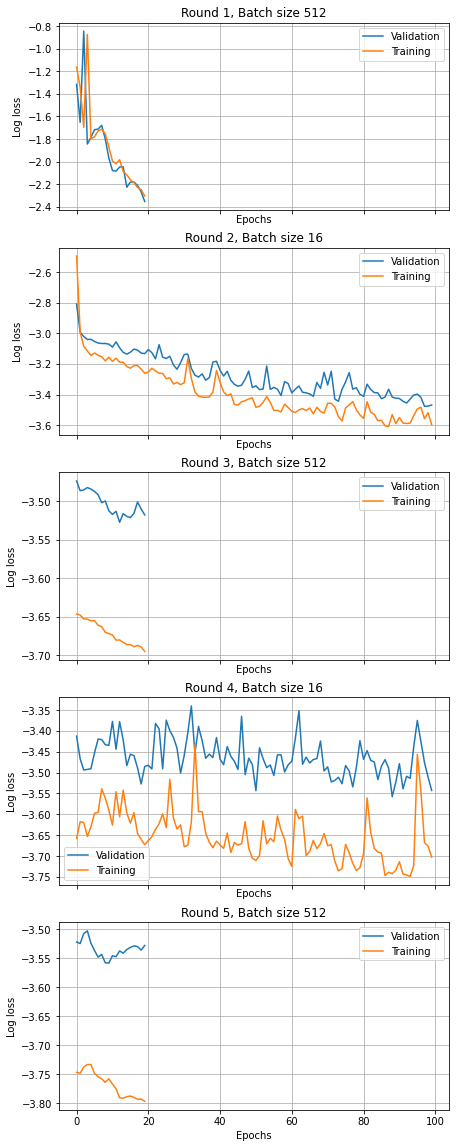

In [11]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(len(history), 1, figsize=(7, len(history)*4), sharex=True)

for i in range(len(history)):

  ax[i].set_title(titles[i])
  ax[i].plot(history[i].epoch, np.log(history[i].history['val_loss']), label='Validation')
  ax[i].plot(history[i].epoch, np.log(history[i].history['loss']), label='Training')
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Log loss')
  ax[i].legend()
  ax[i].grid()


### Results

#### Encode the data

In [12]:
encoded_data=encoder.predict(qt).flatten()
encoded_data.shape

(506,)

#### Generate types

In [13]:
min_x, max_x, grid_n = -2, 2, 401
grid_x = np.linspace(min_x,max_x,grid_n)
decoded=decoder.predict(grid_x)
decoded.shape

(401, 13)

#### Cluster features

In [0]:
n_grid_lines=21
grid_lines = np.linspace(min_x,max_x,n_grid_lines)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


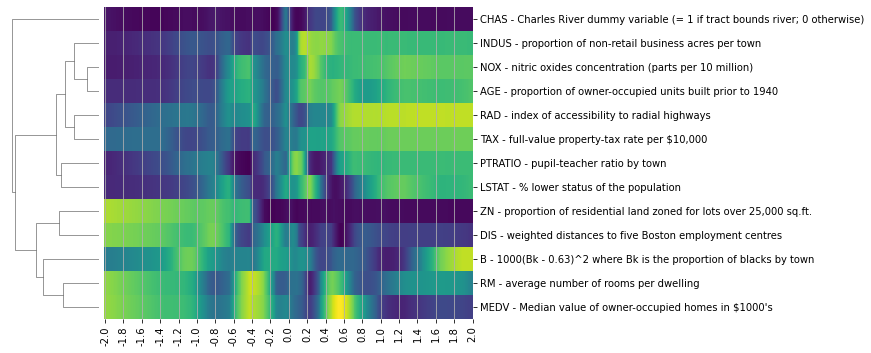

In [15]:
import seaborn as sns

clustergrid = sns.clustermap(decoded.T,cmap='viridis', 
                             cbar_kws={'orientation':'horizontal'},
                             figsize = (7,5),
                             col_cluster= False, dendrogram_ratio=(0.2,0.0001), 
                             cbar_pos=None)

ax = clustergrid.ax_heatmap
feature_order = clustergrid.dendrogram_row.reordered_ind
ordered_labels = [data.columns[i] for i in feature_order] 
ax.set_xticks(np.linspace(1,grid_n,n_grid_lines))
ax.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
ax.set_yticklabels(ordered_labels)
ax.tick_params(axis='y',labelright=True, labelleft=False, 
                 left=False, labelrotation=0)
ax.grid(axis='x')

#### Plot type distribution

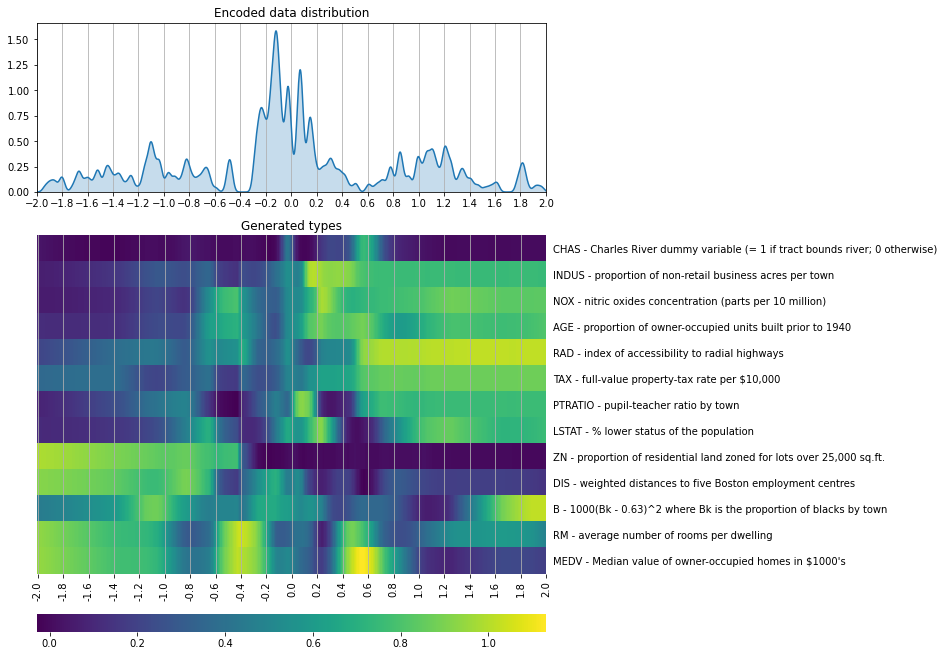

In [16]:
import seaborn as sns

fig = plt.figure(figsize=(13,9),constrained_layout=True)
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1:,:])

ax1.set_title('Encoded data distribution')
sns.kdeplot(encoded_data,bw=0.02, shade = True, ax=ax1, gridsize=2000)
ax1.set_xticks( grid_lines )
ax1.set_xlim(min_x,max_x)
ax1.grid(axis='x')

ax2.set_title('Generated types')

sns.heatmap(decoded.T[feature_order],cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
ax2.set_xticks(np.linspace(1,grid_n,n_grid_lines))
ax2.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
ax2.set_yticklabels(ordered_labels)
ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                left=False, labelrotation=0)
ax2.grid(axis='x')


In [0]:
def plot_type_dist_list(encoded_data_list, grid_x, decoded, 
                        type_labels, vertical_n, dist_labels):

  fig = plt.figure(figsize=(13,vertical_n*3),constrained_layout=True)
  gs = fig.add_gridspec(vertical_n, 1)
  ax1 = fig.add_subplot(gs[0,:])
  ax2 = fig.add_subplot(gs[1:,:])

  n_grid_lines=21
  min_x, max_x, grid_n = grid_x[0], grid_x[-1], len(grid_x)
  grid_lines = np.linspace(min_x,max_x,n_grid_lines)

  ax1.set_title('Encoded data distribution')
  for i in range(len(encoded_data_list)):
    sns.kdeplot(encoded_data_list[i],bw=0.02, shade = True, 
                ax=ax1, gridsize=2000, label=dist_labels[i])
  ax1.set_xticks( grid_lines )
  ax1.set_xlim(min_x,max_x)
  ax1.grid(axis='x')

  ax2.set_title('Generated types')

  sns.heatmap(decoded.T,cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
  ax2.set_xticks(np.linspace(1,grid_n,n_grid_lines))
  ax2.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
  ax2.set_yticklabels(type_labels)
  ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                  left=False, labelrotation=0)
  ax2.grid(axis='x')

In [0]:
targets = targets.values.flatten()

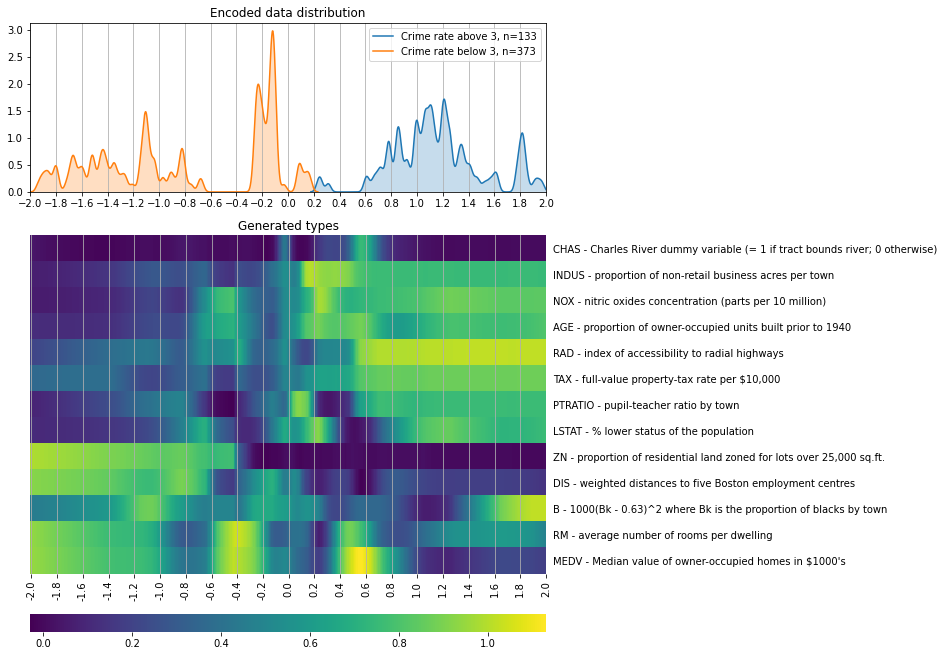

In [19]:
plot_type_dist_list([encoded_data[targets>3],
                     encoded_data[targets<=0.1]], 
                    grid_x, decoded[:,feature_order], 
                    type_labels=ordered_labels, vertical_n=3,
                    dist_labels = ['Crime rate above 3, n={}'.format(sum(targets>3)),
                                   'Crime rate below 3, n={}'.format(sum(targets<=3))])